**第3章 分类**

@Author: Rui Zhu<br>
@Date: 2025-01-07

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

dir_data = Path("/Users/rui/Code/Astronote/05_Scikit-Learn/book2_机器学习实战/data")

---
# MNIST数据集

In [2]:
from sklearn.datasets import fetch_openml, load_digits

mnist = fetch_openml('mnist_784', as_frame=False, data_home=dir_data)

In [3]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape  # 7w张图像, 每张图像有784个特征即28x28像素

((70000, 784), (70000,))

True label: 7


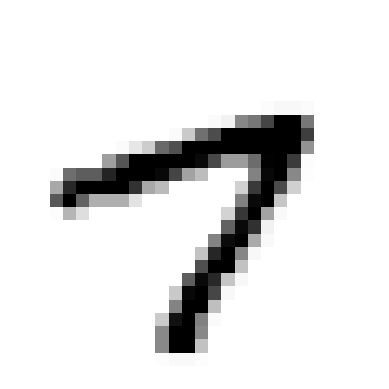

In [4]:
# 显示样本图像
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

idx = 101
plot_digit(X[idx])
print(f"True label: {y[idx]}")

In [5]:
# 测试集划分
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)
print(f"N of train set: {len(X_train)}, N of test set: {len(X_test)}")

N of train set: 60000, N of test set: 10000


---
# 二元分类器
- 多分类任务可以看作多个二分类器的组合
- 作为实例, 这里做一个“5检测器”

In [6]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

# 训练模型
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

True label: 5
Predict: [ True]


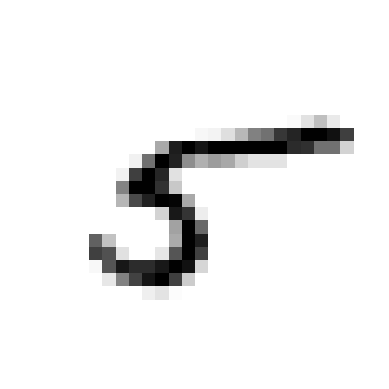

In [7]:
# 随机检查

idx = 105
print(f"True label: {y_test[idx]}")
print(f"Predict: {sgd_clf.predict([X_test[idx]])}")
plot_digit(X_test[idx])

---
# 分类器的性能评估

## 交叉验证
- 交叉验证是评估模型的一种方法
- k折交叉验证指: 将训练集分成k个折叠, 然后做k次训练, 每次使用其中一个折叠作为验证集, 其余数据用于训练

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9629 , 0.96775, 0.96435])

In [9]:
# 虚构的分类器
# 说明在不平衡的样本中, 即便全部预测为负样本, 也能有很高的准确率
# 说明准确率不是一个好的评价指标, 尤其在不平衡的数据集中
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))  # any()函数有True则True, 没有True则False

False


In [10]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9104, 0.9104, 0.9104])

In [11]:
# 手动实现交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_folds = X_train[test_idx]
    y_test_folds = y_train_5[test_idx]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9546
0.9709
0.96305


## 混淆矩阵
- accuracy在不平衡样本中会表现出欺骗性, 更好的性能评估是查看混淆矩阵

In [12]:
# 使用cross_val_predict()函数得到交叉验证的预测结果
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[54103,   521],
       [ 1579,  3797]])

In [14]:
# 一个完美的预测
y_train_perfect_pred = y_train_5
cm_perfect = confusion_matrix(y_train_5, y_train_perfect_pred)
cm_perfect

array([[54624,     0],
       [    0,  5376]])

## 准确率与召回率
- 准确率(percision): $\rm{\frac{TP}{TP + FP}}$, 即预测的样本中有多少是正确的
- 召回率(recall): $\rm\frac{TP}{TP + FN}$, 即阳性样本中，有多少被正确预测

In [15]:
cm

array([[54103,   521],
       [ 1579,  3797]])

In [16]:
percision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f"Percision: {percision}, Recall: {recall}")

Percision: 0.8793422880963409, Recall: 0.7062872023809523


In [17]:
from sklearn.metrics import precision_score, recall_score

percision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print(f"Percision: {percision}, Recall: {recall}")

Percision: 0.8793422880963409, Recall: 0.7062872023809523


## F1分数
- F1分数是准确率和召回率的调和平均: $\rm F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$
- 调和平均对低值赋予更高的权重
- 因此只有precision和recall都很高时, F1才会有较高的分数

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.783371157416959)

## 准确率和召回率作为阈值的函数
- percision-recall权衡:
    1. 分类器的结果是根据决策函数作为判断的, 预测分数大于阈值为阳性
    2. 升高决策阈值会提高准确率但会降低召回率

### 输出决策分数
- sklearn不允许直接设置阈值, 但可以访问决策分数

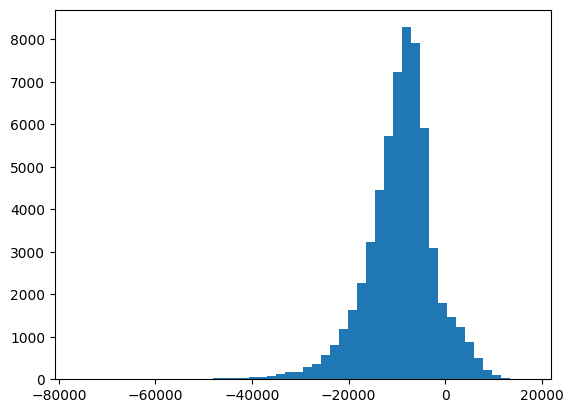

In [19]:
y_scores = sgd_clf.decision_function(X_train)
plt.hist(y_scores, bins=50);

In [20]:
# 获取训练集中所有实例的验证分数
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method='decision_function'
    )

### PR-threshold curve

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Text(0, 0.5, 'Score')

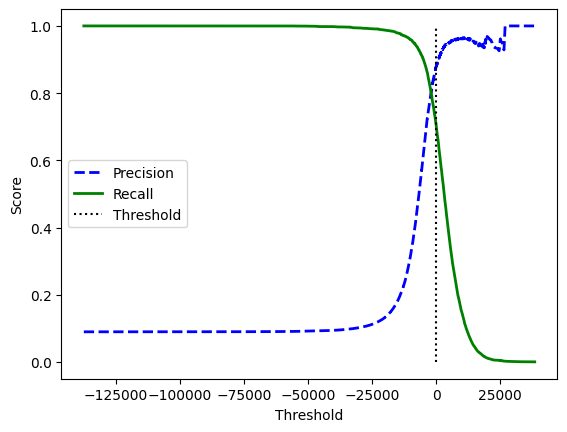

In [22]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", lw=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", lw=2)
plt.vlines(5, 0, 1.0, 'k', 'dotted', label='Threshold')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")

## 准确率-召回率曲线 (PR曲线)
- PR Cure (percision-recall curve)

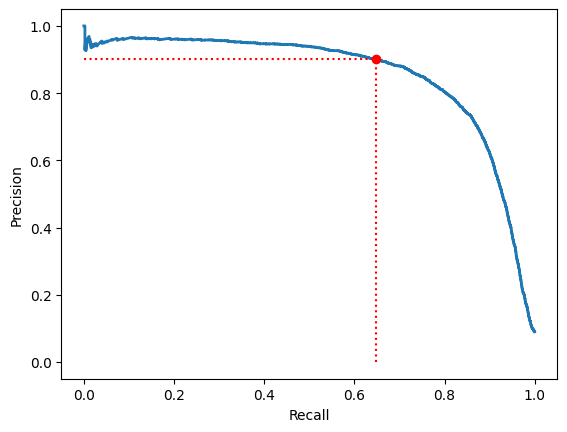

In [23]:
plt.plot(recalls, precisions, lw=2, label='Precision/Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")

# 搜索达到90%的准确率的最小阈值
idx = np.argmax(precisions >= 0.90)
threshold_90_precision = thresholds[idx]
percision_90 = precisions[idx]
recall_90 = recalls[idx]

plt.plot(recall_90, percision_90, 'ro')
plt.vlines(recall_90, 0, percision_90, 'r', 'dotted')
plt.hlines(percision_90, 0, recall_90, 'r', 'dotted')

In [24]:
# 输出更新阈值后的结果
y_train_pred_90 = (y_scores >= threshold_90_precision)
percision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)

print(f"Percision: {percision_90}, Recall: {recall_90}")

Percision: 0.9001293661060802, Recall: 0.6471354166666666


In [25]:
from sklearn.metrics import auc

# 计算PR曲线下的面积, 越接近1说明模型越好
auc(recalls, precisions)

np.float64(0.8539808206914135)

## ROC曲线
- 受试者操作特征(Receiver Operating Characteristic, ROC)
- 历史:
    1. ROC的概念最初来源于第二次世界大战时期的雷达信号检测研究。
    2. 当时，科学家们需要评估雷达系统的性能，即如何区分真实信号（敌方飞机）和背景噪声（虚假信号）。在这种情况下：
    3. True Positive(真正检测到敌机)和False Positive(误判噪声为敌机)是关键指标。
	4. 系统需要权衡检测灵敏度（检测到的敌机越多越好）和误报率（避免过多误报敌机），这正是ROC分析的核心。
    5. 最初的研究由信号检测理论领域的科学家完成，ROC曲线被用来描述雷达接收机（Receiver）的操作特性（Operating Characteristic），因此得名。
- ROC曲线绘制的是TPR和FPR在各个分类阈值下的对应关系, 用于评估分类器性能
- True Positive Rate (TPR): 即Recall, 也称真阳性率, 即正确分类为阳性的阳性样本比例
- False Positive Rate (FPR): 假阳性率, 也称fall-out, 即错误分类成阳性样本的阴性样本比例

- $\rm TPR = \frac{TP}{TP + FN}$
- $\rm FPR = \frac{FP}{TN + FP}$

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

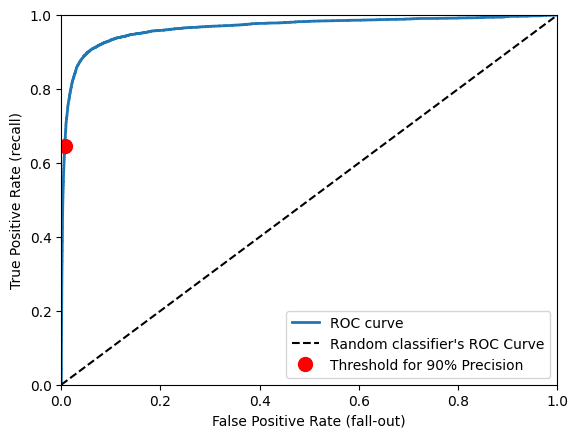

In [27]:
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, lw=2, label='ROC curve')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate (fall-out)")
plt.ylabel("True Positive Rate (recall)")

plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC Curve")
plt.plot(fpr_90, tpr_90, 'ro', ms=10, label='Threshold for 90% Precision')
plt.legend()

In [28]:
# 计算ROC曲线下的面积, 越接近1说明模型越好
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9667375476090224)

In [29]:
# 另一种方法
auc(fpr, tpr)

np.float64(0.9667375476090224)

---
# 分类器性能比较
- sklearn直接输出的概率是估计概率不是实际概率
- 参考: https://scikit-learn.org/stable/auto_examples/calibration/index.html

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method='predict_proba'
    )

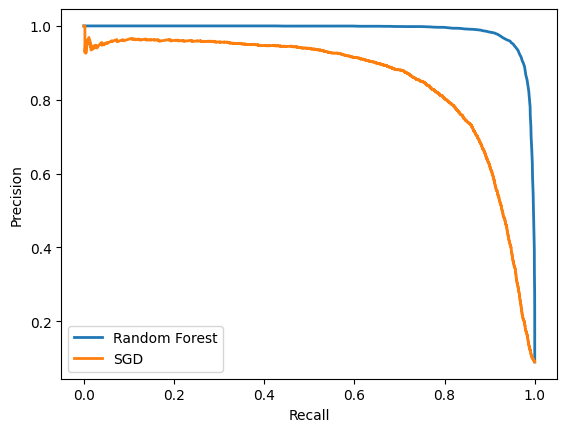

In [31]:
y_scores_forest = y_probas_forest[:, 1]  # 获得正类的概率
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, lw=2, label='Random Forest')
plt.plot(recalls, precisions, lw=2, label='SGD')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

In [32]:
positive_proba = 0.5
y_train_pred_forest = (y_scores_forest >= positive_proba)
f1 = f1_score(y_train_5, y_train_pred_forest)
auc_score = roc_auc_score(y_train_5, y_scores_forest)
print(f"F1: {f1}, AUC: {auc_score}")

F1: 0.9278798656392018, AUC: 0.9984810883674236


---
# 多类分类器
- 原生支持多类分类的算法: Logistic, RandomForest, GaussianNB, XGBoost
- 严格二分类器: SVC, SGD
- 二分类器可以通过一些策略实现多分类:
    1. one-versus-the Rest, OvR策略, 也称One-Versus-All, OvA
    2. One-versus-One, OvO策略
- 对于大多数二元分类算法, OvR是首选

## sklearn会自动尝试OvR或OvO

In [33]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

['1']


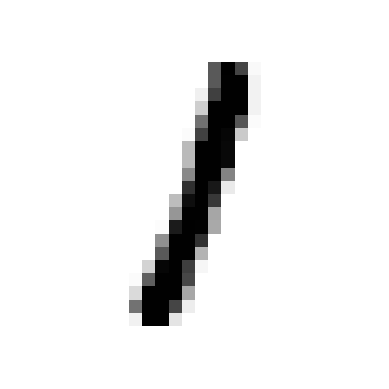

In [38]:
print(svm_clf.predict([X_train[100]]))
plot_digit(X_train[100])

In [39]:
some_digit_scores = svm_clf.decision_function([X_train[100]])
some_digit_scores.round(2)

array([[-0.3 ,  9.31,  8.27,  6.14,  0.72,  5.  ,  3.81,  1.75,  7.26,
         2.75]])

In [41]:
svm_clf.classes_[np.argmax(some_digit_scores)]

'1'

## 强制使用OvR或OvO策略

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
cross_val_score(ovr_clf, X_train[:2000], y_train[:2000], cv=3, scoring='accuracy')

array([0.92653673, 0.91754123, 0.91741742])

In [46]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SVC(random_state=42))
cross_val_score(ovo_clf, X_train[:2000], y_train[:2000], cv=3, scoring='accuracy')

array([0.92203898, 0.93403298, 0.92942943])

---
# 错误分析

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

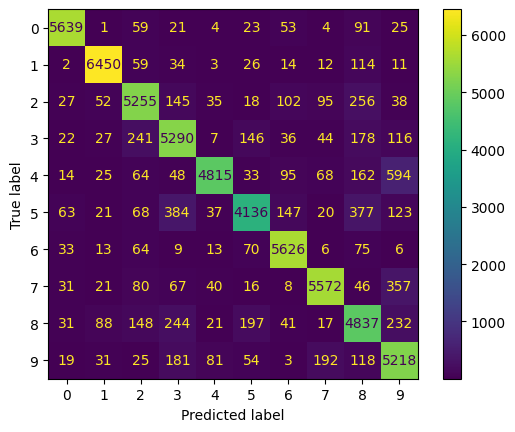

In [49]:
# 标准混淆矩阵
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

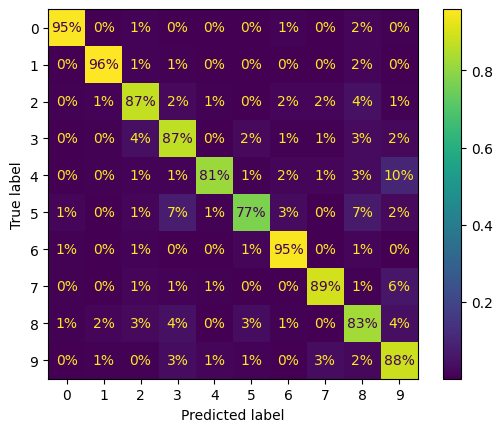

In [51]:
# 将每个值除以真实类别的数量(即除以行的总和)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')